## SARIMA

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import statsmodels.tsa.api as smt
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
from tqdm import tqdm_notebook
from itertools import product

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
DATAPATH = 'https://raw.githubusercontent.com/marcopeix/stock-prediction/master/data/stock_prices_sample.csv'

In [10]:
data = pd.read_csv(DATAPATH, index_col=['DATE'], parse_dates=['DATE'])
data.head(10)

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.2300,47.3700,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.1400,46.4800,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.1600,46.4100,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.8700,18.8700,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.7900,18.8100,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0
2018-06-01,GF,BBG000C3C6S2,EOD,daily,18.58,18.7600,18.5800,18.7400,17468.0,18.580000,18.760000,18.580000,18.740000,17468.0,NaN,0.0,1.0
2018-05-31,GF,BBG000C3C6S2,EOD,daily,18.52,18.5200,18.3012,18.4900,22384.0,18.520000,18.520000,18.301200,18.490000,22384.0,NaN,0.0,1.0
2018-05-30,GF,BBG000C3C6S2,EOD,daily,18.47,18.6780,18.4700,18.6500,22633.0,18.470000,18.678000,18.470000,18.650000,22633.0,NaN,0.0,1.0
2018-05-29,GF,BBG000C3C6S2,EOD,daily,18.51,18.5100,18.1500,18.2562,67412.0,18.510000,18.510000,18.150000,18.256200,67412.0,NaN,0.0,1.0


In [7]:
data = data[data.TICKER != 'GEF']
data = data[data.TYPE != 'Intraday']
drop_cols = ['SPLIT_RATIO', 'EX_DIVIDEND', 'ADJ_FACTOR', 'ADJ_VOLUME', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH', 'ADJ_OPEN', 'VOLUME', 'FREQUENCY', 'TYPE', 'FIGI']
data.drop(drop_cols, axis=1, inplace=True)
data.head()

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100
2018-06-01,GF,18.58,18.760,18.5800,18.7400
2018-05-31,GF,18.52,18.520,18.3012,18.4900
2018-05-30,GF,18.47,18.678,18.4700,18.6500
2018-05-29,GF,18.51,18.510,18.1500,18.2562


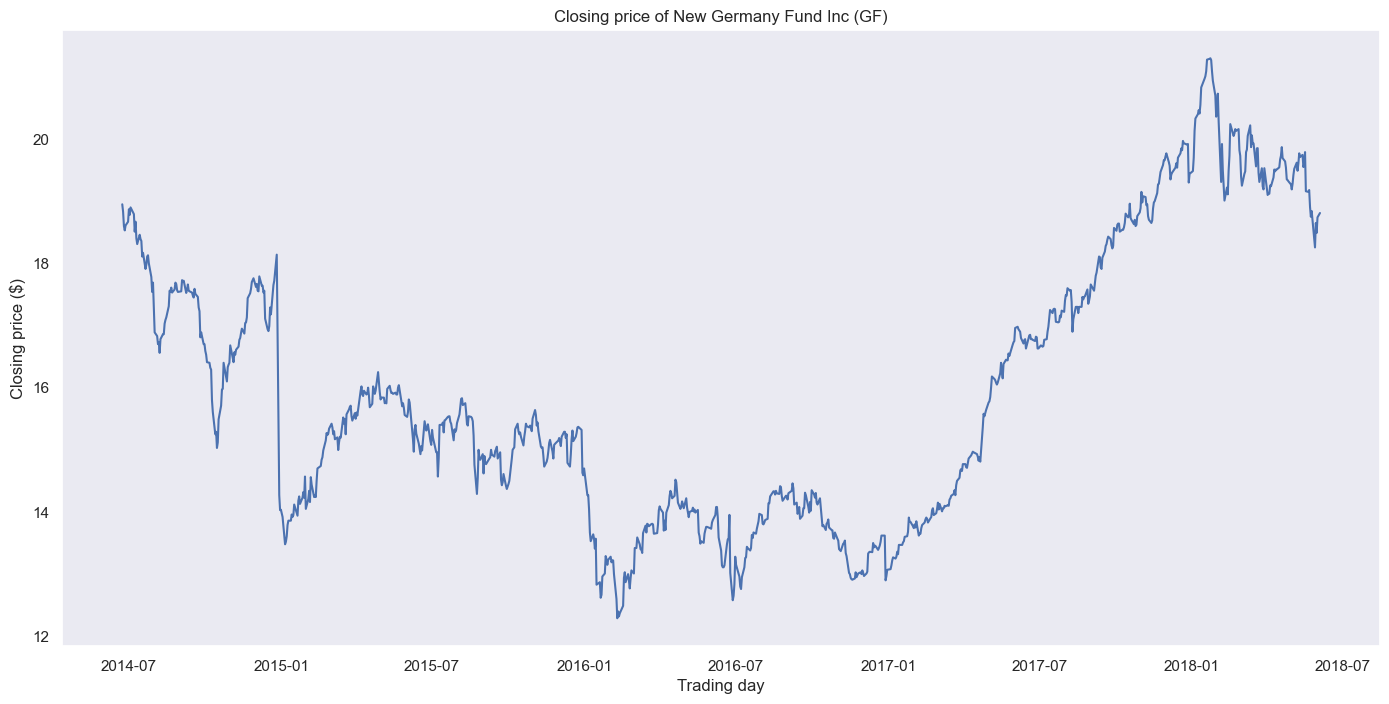

In [8]:
# Мы видим, что процесс нестационарный, и трудно сказать, есть ли какая-то сезонность.
plt.figure(figsize=(17, 8))
plt.plot(data.CLOSE)
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

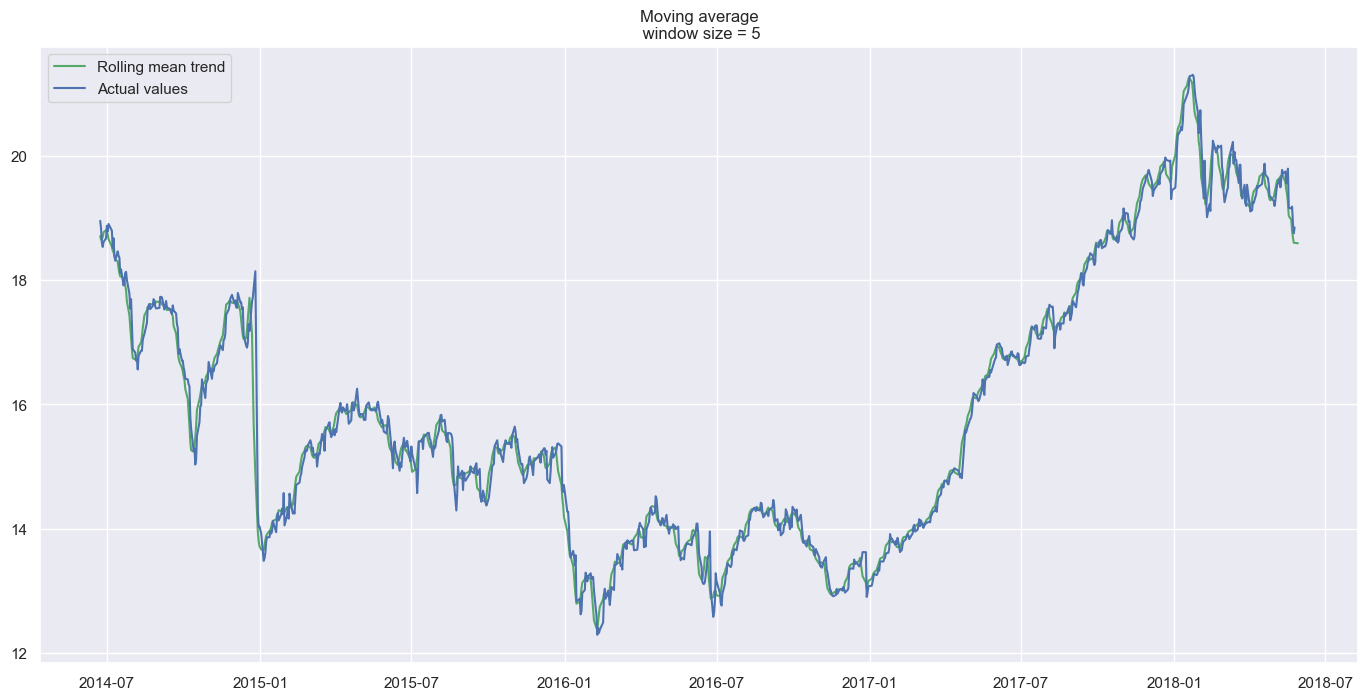

In [9]:
# Построим графики скользящей средней
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

plot_moving_average(data.CLOSE, 5)

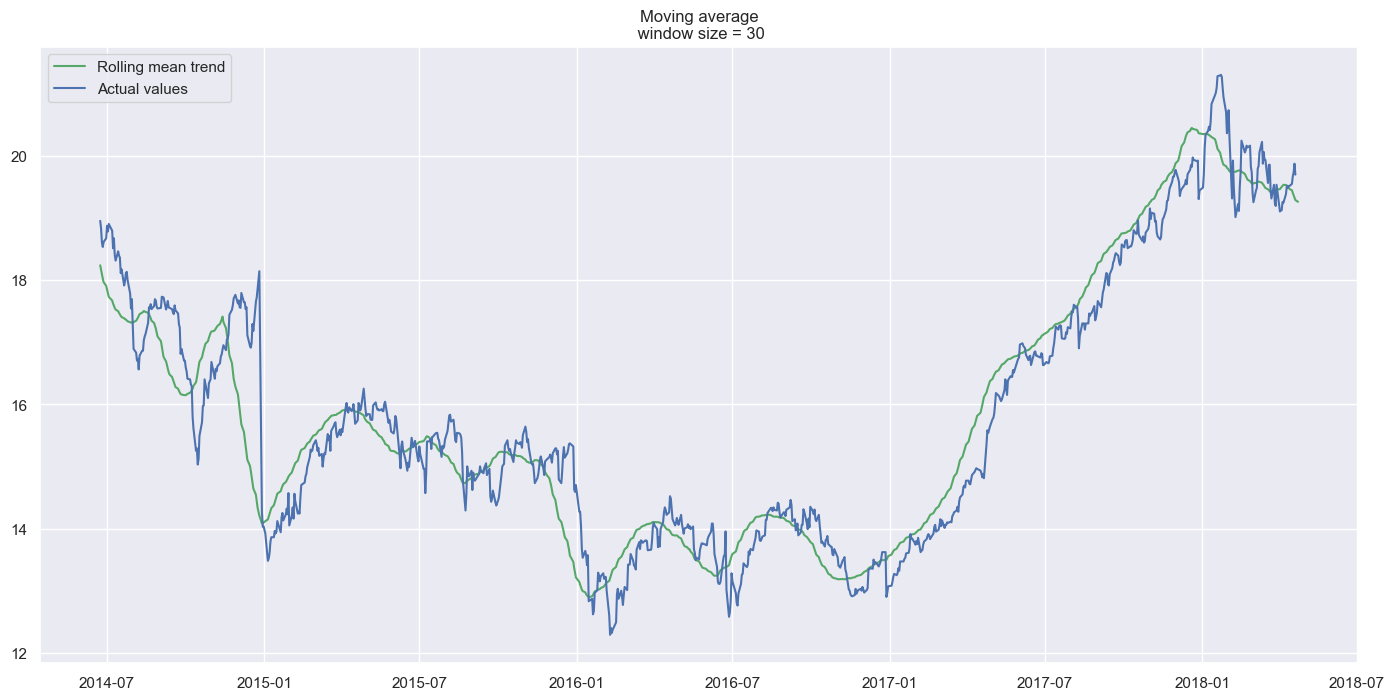

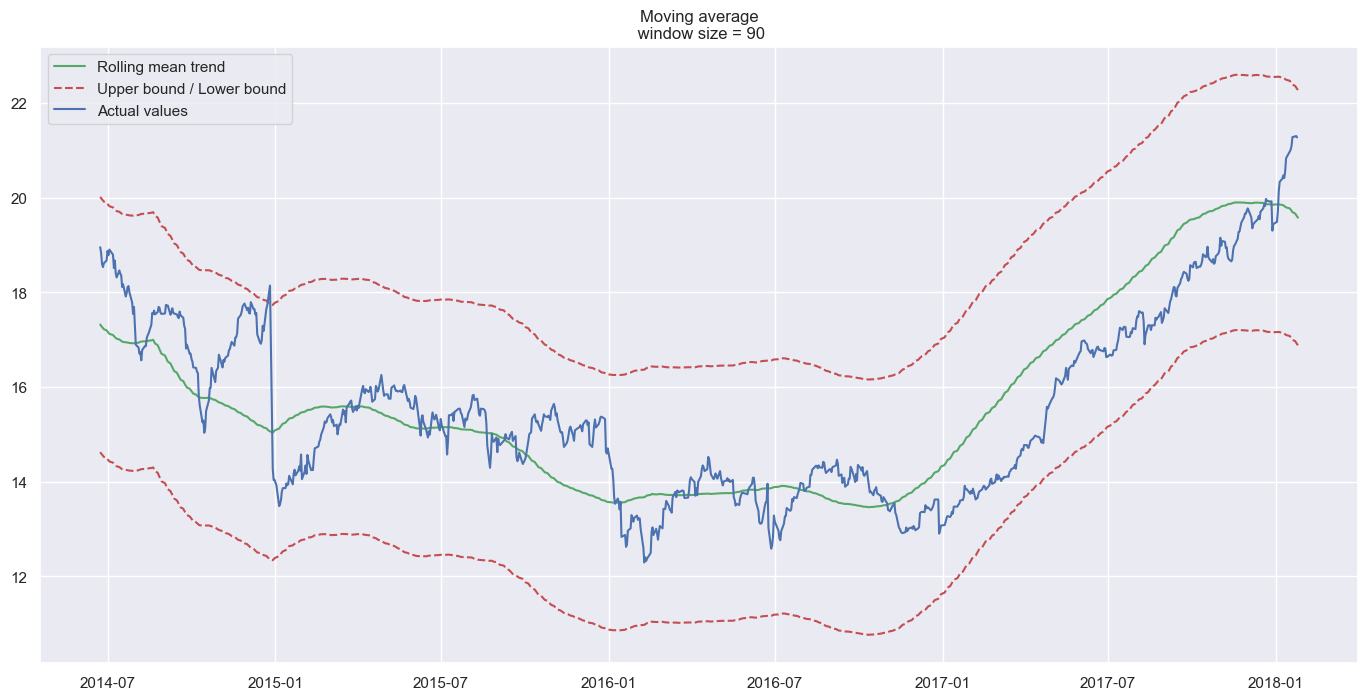

In [10]:
# Мы почти не видим тренда, потому что он слишком близок к реальной кривой.
# Посмотрим результат сглаживания по предыдущему месяцу и предыдущему кварталу.
plot_moving_average(data.CLOSE, 30)
plot_moving_average(data.CLOSE, 90, plot_intervals=True)

In [11]:
# Тенденции теперь легче заметить. 30-дневный и 90-дневный тренд показывает нисходящую кривую в конце.
# Это может означать, что акции, вероятно, упадут в ближайшие дни.

In [12]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

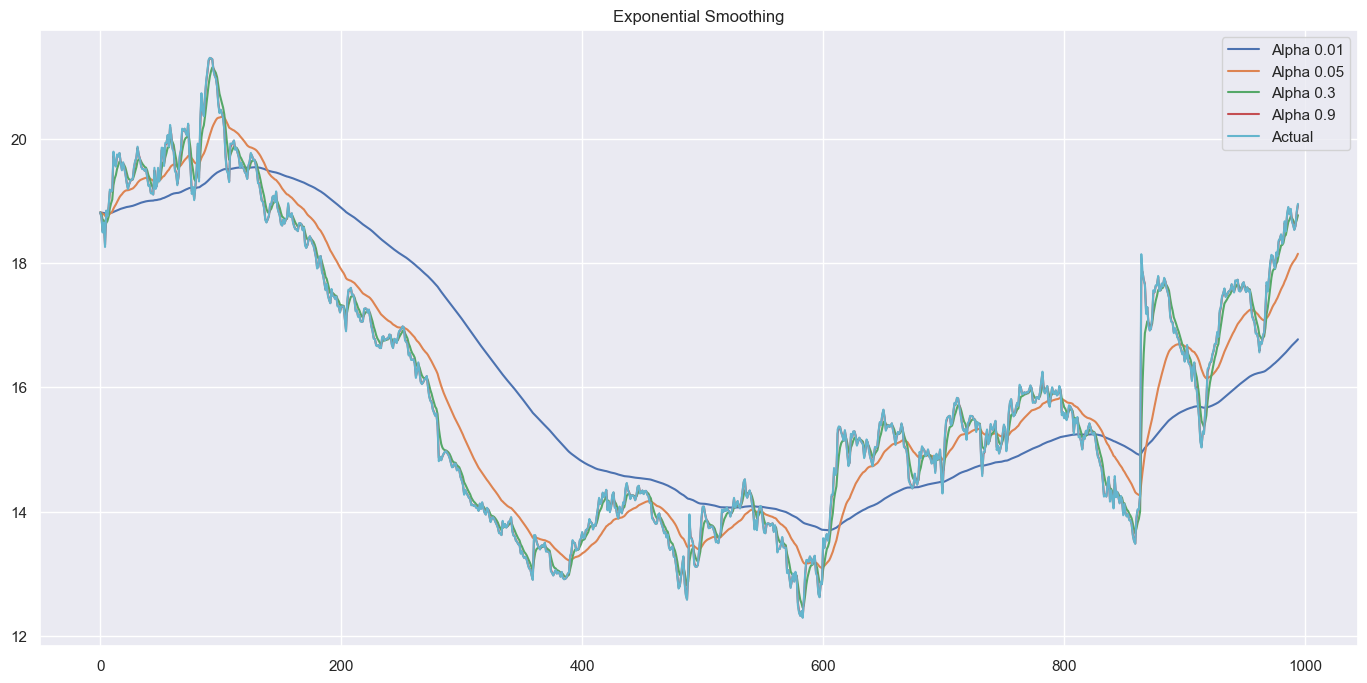

In [13]:
# Коэффициент alpha принимает значения от 0 до 1, отвечает за влияние более старых наблюдений.
# Если alpha = 1, то кривая повторяет исходный график
plot_exponential_smoothing(data.CLOSE, [0.01, 0.05, 0.3, 0.9])

In [14]:
# Двойное экспоненциальное сглаживание
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result


def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

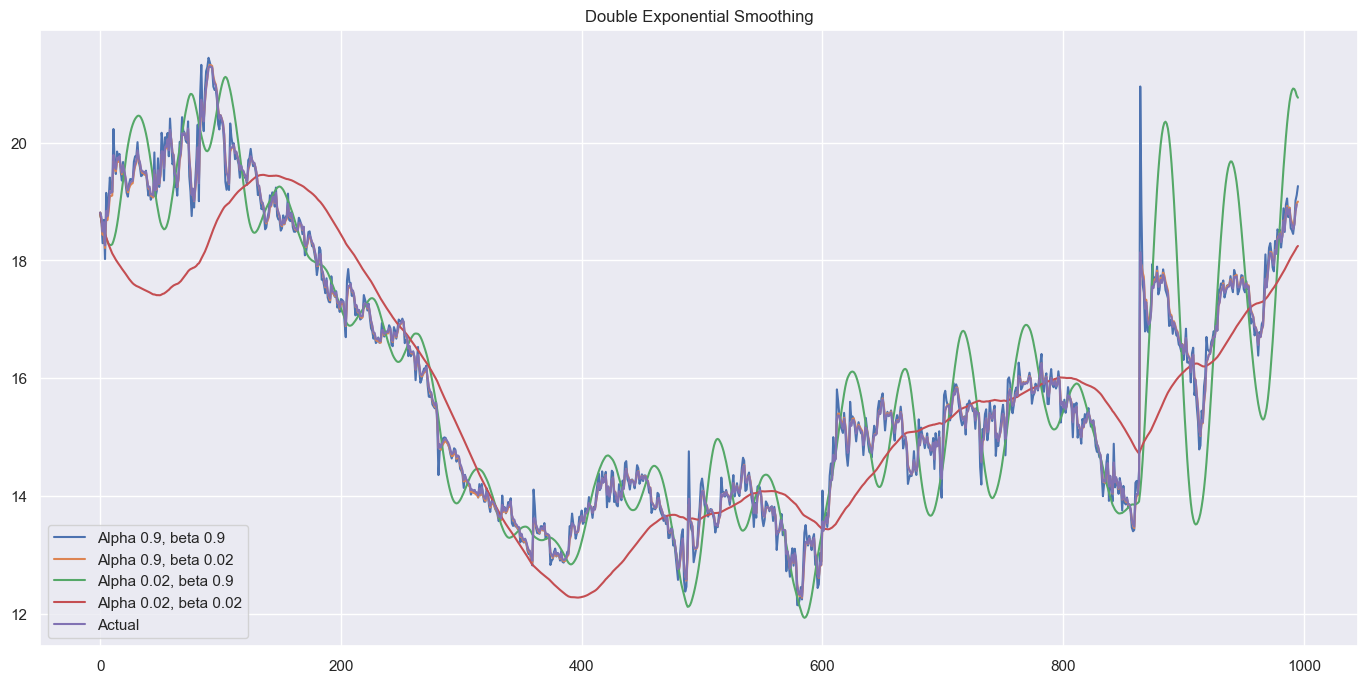

In [15]:
plot_double_exponential_smoothing(data.CLOSE, alphas=[0.9, 0.02], betas=[0.9, 0.02])

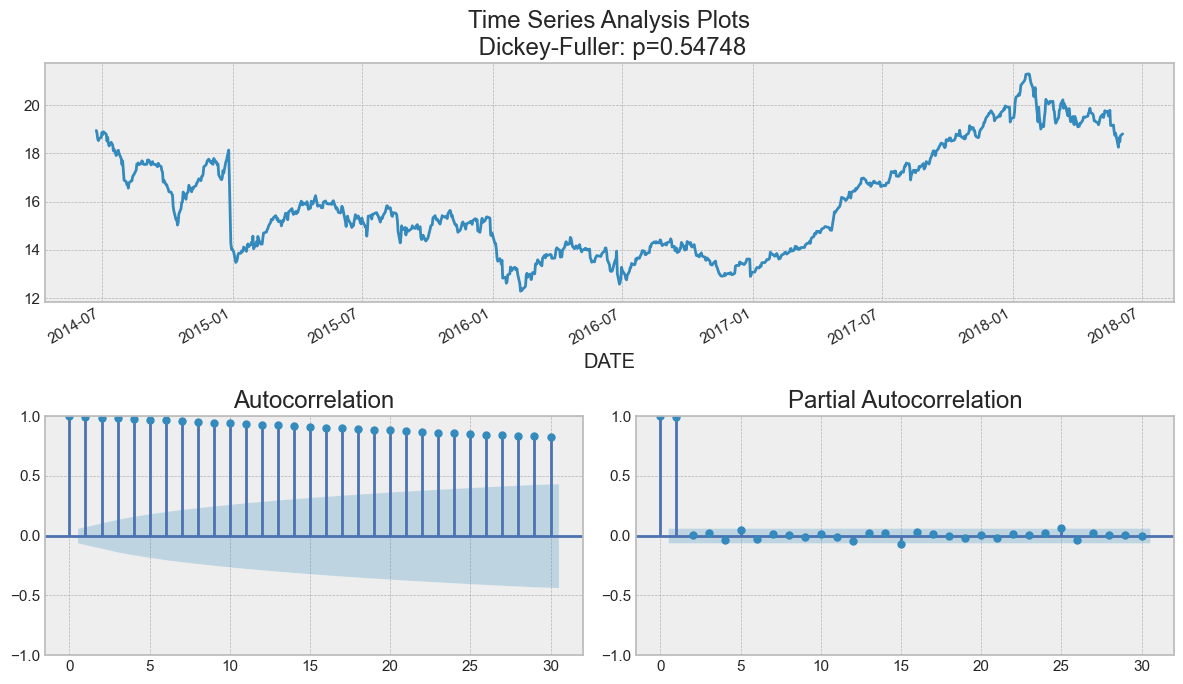

In [16]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


tsplot(data.CLOSE, lags=30)
# Мы видим, что график ACF снижается постепенно, PACF падает мгновенно. Следует использовать авторегрессионную модель.

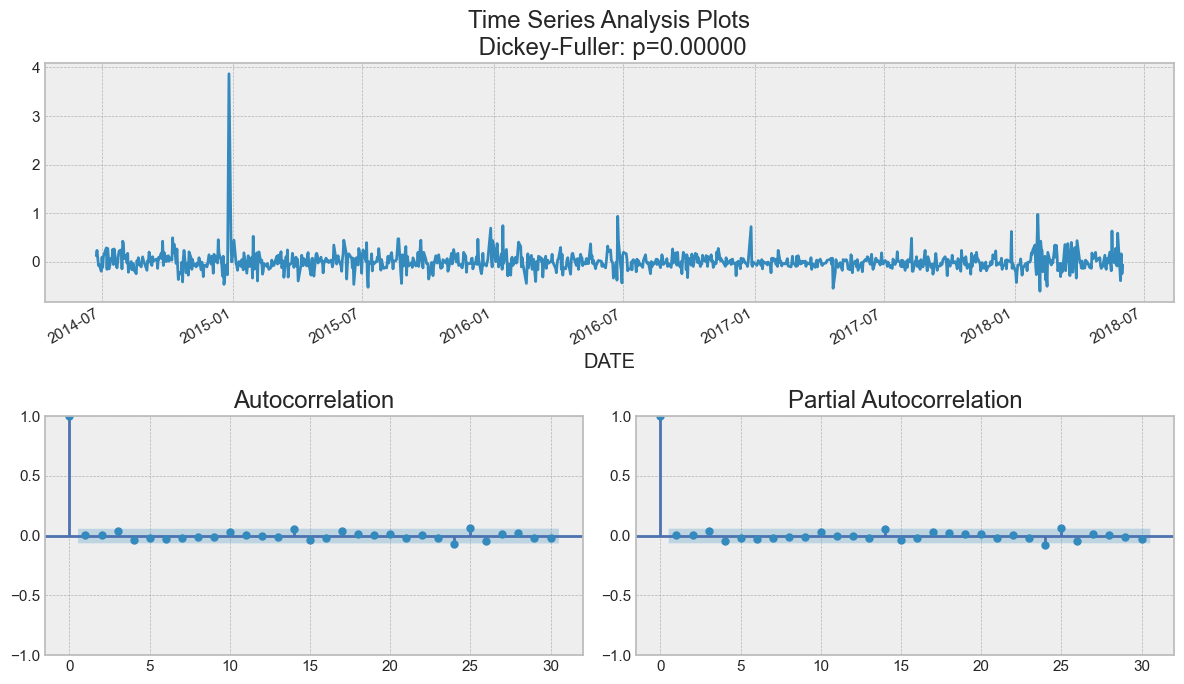

In [17]:
# Чтобы избавиться от высокой автокорреляции и сделать процесс стационарным
# вычитаем временной ряд из самого себя с лагом в один день.
data_diff = data.CLOSE - data.CLOSE.shift(1)
tsplot(data_diff[1:], lags=30)

In [25]:
# Великолепно! Теперь наш временной ряд стационарен и мы можем приступить к моделированию!
# Зададим диапазоны для генерации значений гиперпараметров.
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

# Создадим список со всеми возможными комбинациями значений.
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)
print(parameters_list[:15])

[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 0, 4), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 1, 2), (0, 0, 1, 3), (0, 0, 1, 4), (0, 0, 2, 0), (0, 0, 2, 1), (0, 0, 2, 2), (0, 0, 2, 3), (0, 0, 2, 4)]


In [ ]:
'''
SARIMA представляет собой комбинацию более простых моделей для создания сложной модели,
которая может моделировать временные ряды, демонстрирующие нестационарные свойства и сезонность.
'''

# Обучим множество моделей SARIMA, чтобы найти лучший набор значений
def optimize_SARIMA(parameters_list, d, D, s):
    # parameters_list — это список со значениями (p, q, P, Q)
    # p — порядок модели AR(p)
    # q — порядок модели MA(q)
    # d — порядок интегрирования
    # P — порядок сезонной составляющей SAR(p)
    # Q — порядок сезонной составляющей SMA(q)
    # D — порядок интегрирования сезонной составляющей
    # s — продолжительность сезона (месяц, квартал, год)
    results = []
    best_aic = float('inf')

    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic

        # Сохраним лучшую модель, значение критерия AIC и параметры.
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # Отсортируем значения, чем меньше AIC тем лучше.
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

In [27]:
# Используем параметры, которые дают наименьшее значение AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                          SARIMAX Results                                           
Dep. Variable:                                        CLOSE   No. Observations:                  995
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2, 3, 4], 5)   Log Likelihood                 148.875
Date:                                      Tue, 18 Apr 2023   AIC                           -283.750
Time:                                              16:56:32   BIC                           -249.473
Sample:                                                   0   HQIC                          -270.716
                                                      - 995                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.4941      0.161  

In [28]:
def plot_SARIMA(series, model, n_steps):
    data = series.copy().rename(columns = {'CLOSE': 'actual'})
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s+d] = np.NaN

    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True)

In [37]:
y_pred = best_model.predict(start=data.CLOSE.shape[0], end=data.CLOSE.shape[0] + 5)
print(y_pred)
print(mean_absolute_percentage_error(data.CLOSE[s+d:], best_model.fittedvalues[s+d:]))

995     18.958700
996     18.966085
997     18.960942
998     18.922731
999     18.944632
1000    18.922262
Name: predicted_mean, dtype: float64
0.7855268055664912


In [59]:
y_true = pd.Series([18.93, 19.23, 19.08, 19.17, 19.11, 19.12])
comparison = pd.concat([y_true.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1, keys=['y_true', 'y_pred']).set_index(pd.date_range(start='2018-06-05', periods=6))
comparison

,y_true,y_pred
2018-06-05,18.93,18.958700
2018-06-06,19.23,18.966085
2018-06-07,19.08,18.960942
2018-06-08,19.17,18.922731
2018-06-09,19.11,18.944632
2018-06-10,19.12,18.922262


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


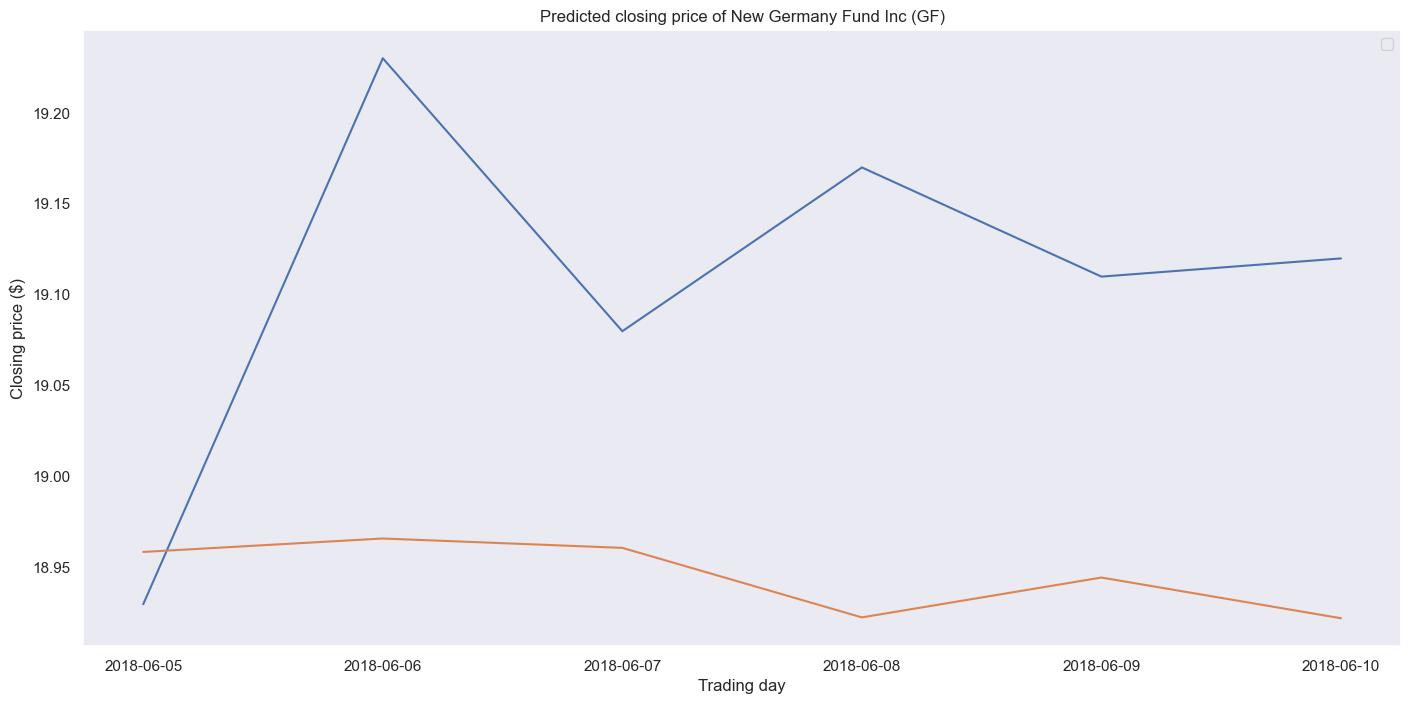

In [61]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.y_true)
plt.plot(comparison.y_pred)
plt.title('Predicted closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()

In [108]:
train, test = data.CLOSE[50:], data.CLOSE[:50]
print(train.index.max())
print(test.index.min())
print(test.index.max())

2018-03-22 00:00:00
2018-03-23 00:00:00
2018-06-04 00:00:00


In [109]:
best_model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [110]:
y_pred = best_model.predict(start=train.shape[0] + 1, end=train.shape[0] + test.shape[0])

In [111]:
comparison = pd.concat([test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1, keys=['y_true', 'y_pred']).set_index(pd.date_range(start=test.index.min(), periods=50))
comparison.head()

,y_true,y_pred
2018-03-23,18.8100,18.963981
2018-03-24,18.7400,18.958600
2018-03-25,18.4900,18.926249
2018-03-26,18.6500,18.946230
2018-03-27,18.2562,18.924513


In [112]:
mean_absolute_percentage_error(comparison.y_true, comparison.y_pred)

1.7089855121202882

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


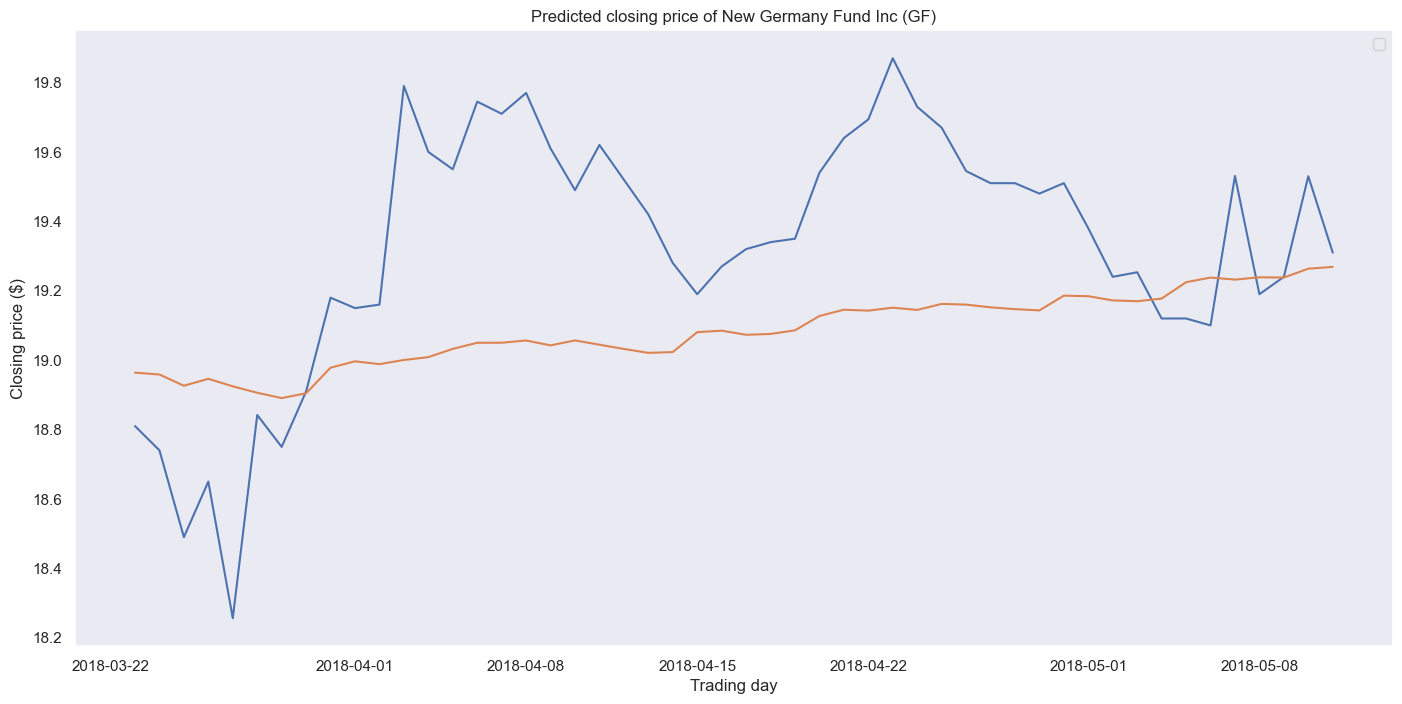

In [113]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.y_true)
plt.plot(comparison.y_pred)
plt.title('Predicted closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()

source: https://github.com/marcopeix/stock-prediction

## Prophet

In [ ]:
!pip install prophet

In [32]:
from prophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

In [49]:
DATAPATH = 'https://raw.githubusercontent.com/marcopeix/air-quality/master/data/AirQualityUCI.csv'
data = pd.read_csv(DATAPATH, sep=';')
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [50]:
# Выполним предварительная обработка данных
data['Date'] = pd.to_datetime(data['Date'])

# Преобразуем значения в формат float
for col in data.iloc[:,2:].columns:
    if data[col].dtypes == object:
        data[col] = data[col].str.replace(',', '.').astype('float')

# Вычислим среднее значение, учитывая только положительные значения
def positive_average(num):
    return num[num > -200].mean()

# Сгруппируем данные
daily_data = data.drop('Time', axis=1).groupby('Date').apply(positive_average)

# Удалим столбцы с более чем 8 NaN
daily_data = daily_data.iloc[:,(daily_data.isna().sum() <= 8).values]

# Удалим строки, содержащие значения NaN
daily_data = daily_data.dropna()

# Сгруппируем данные по неделям
weekly_data = daily_data.resample('W').mean()
weekly_data.head()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,
2004-01-04,1244.380952,11.971429,1010.428571,880.666667,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-11,1136.801760,11.674457,1009.344462,760.484990,1727.833075,1083.683747,24.564726,53.224017,1.526858
2004-01-18,1173.375000,13.429167,1050.458333,1490.333333,1448.541667,1196.333333,10.891667,77.000000,1.002796
2004-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Построим графики недельной концентрации каждого типа газа
def plot_data(col):
    plt.figure(figsize=(17, 8))
    plt.plot(weekly_data[col])
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(False)
    plt.show()

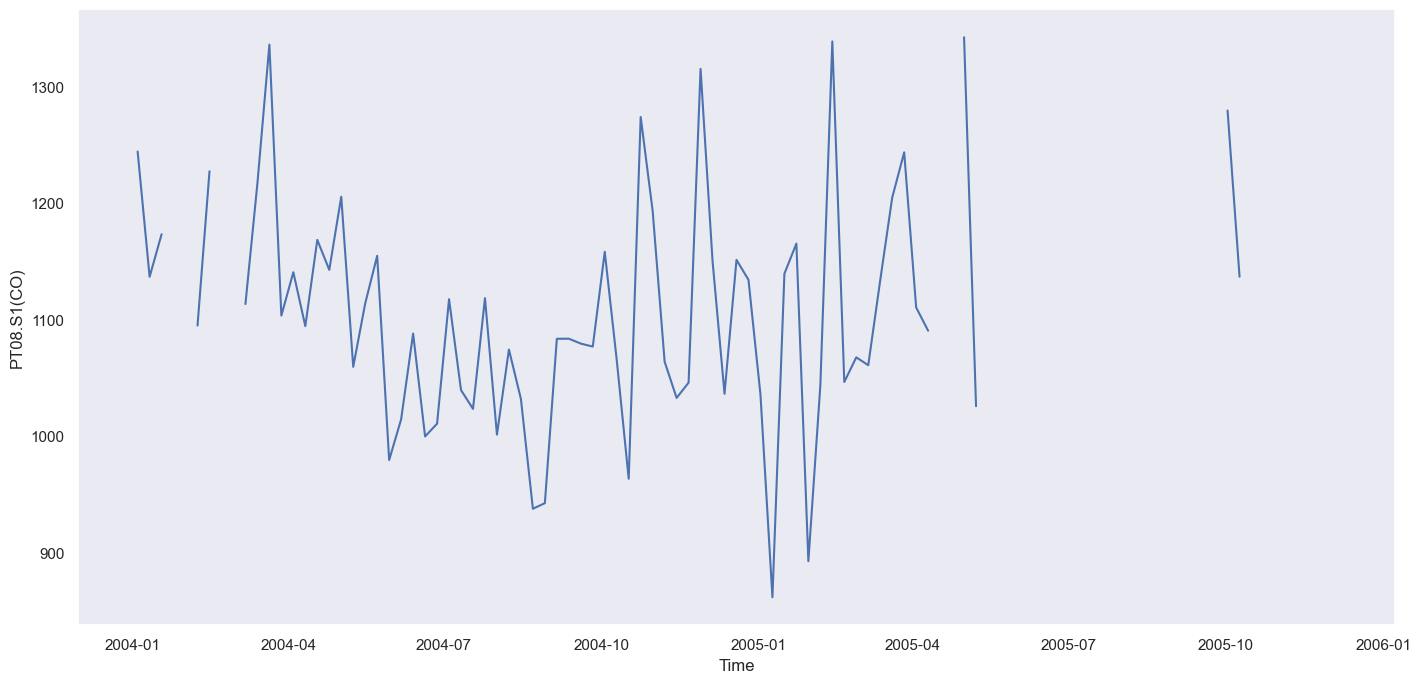

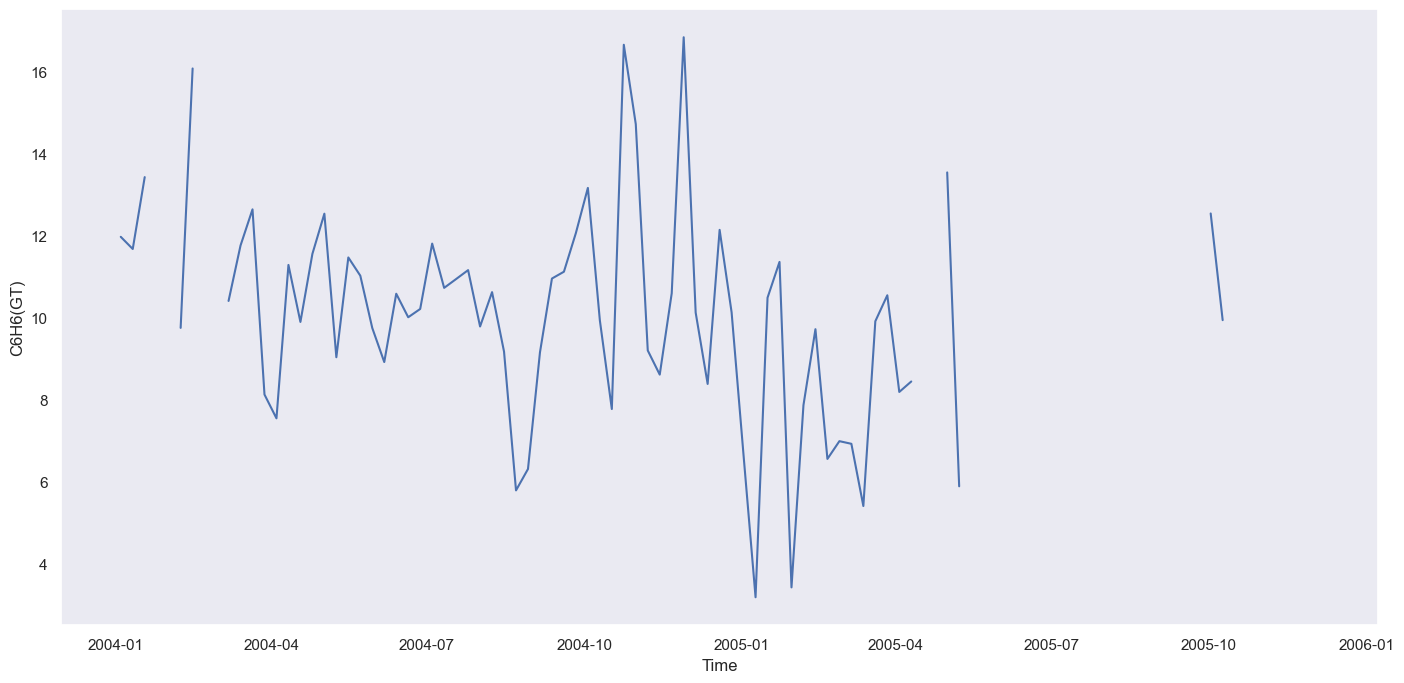

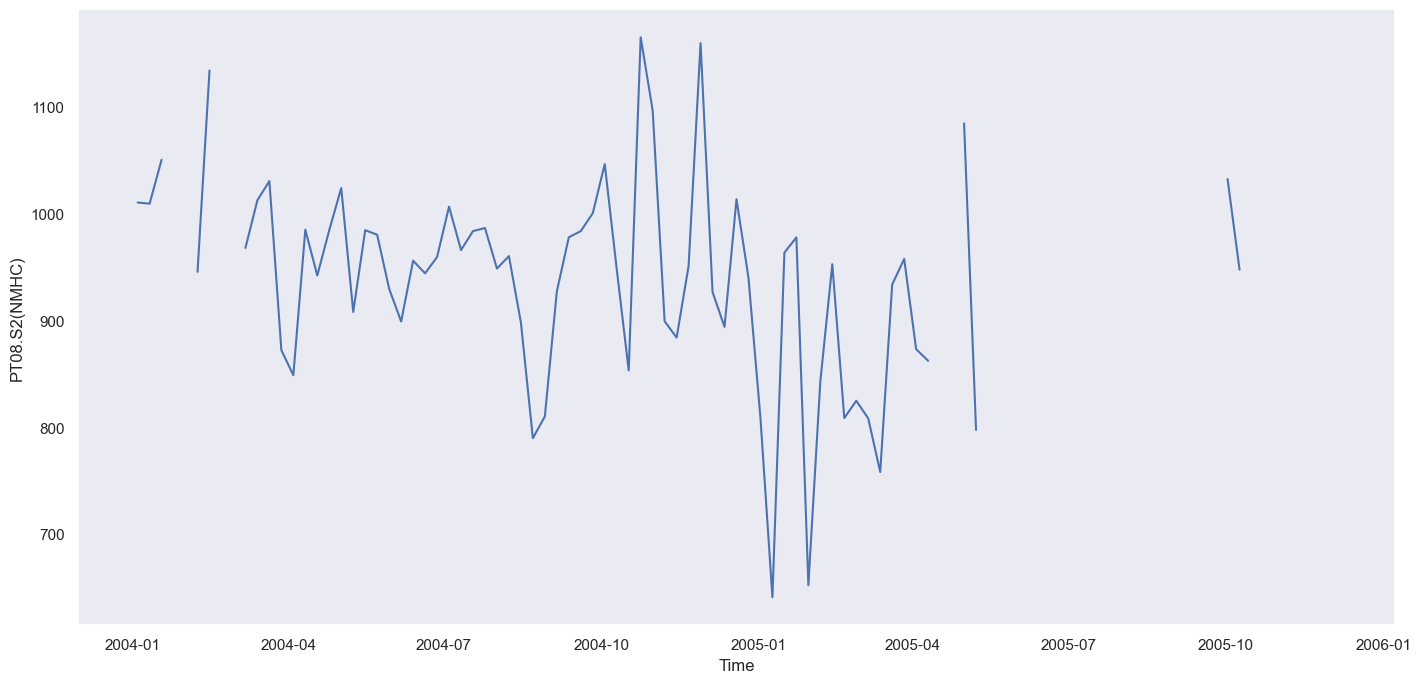

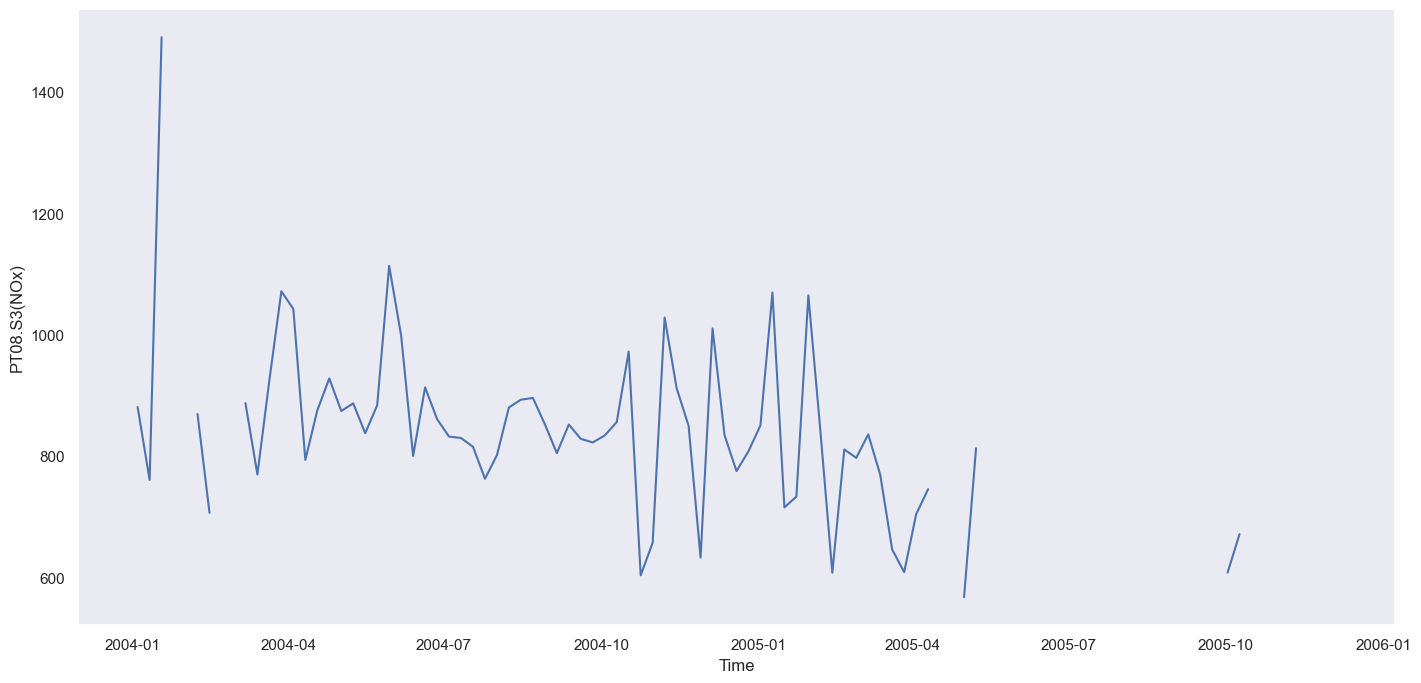

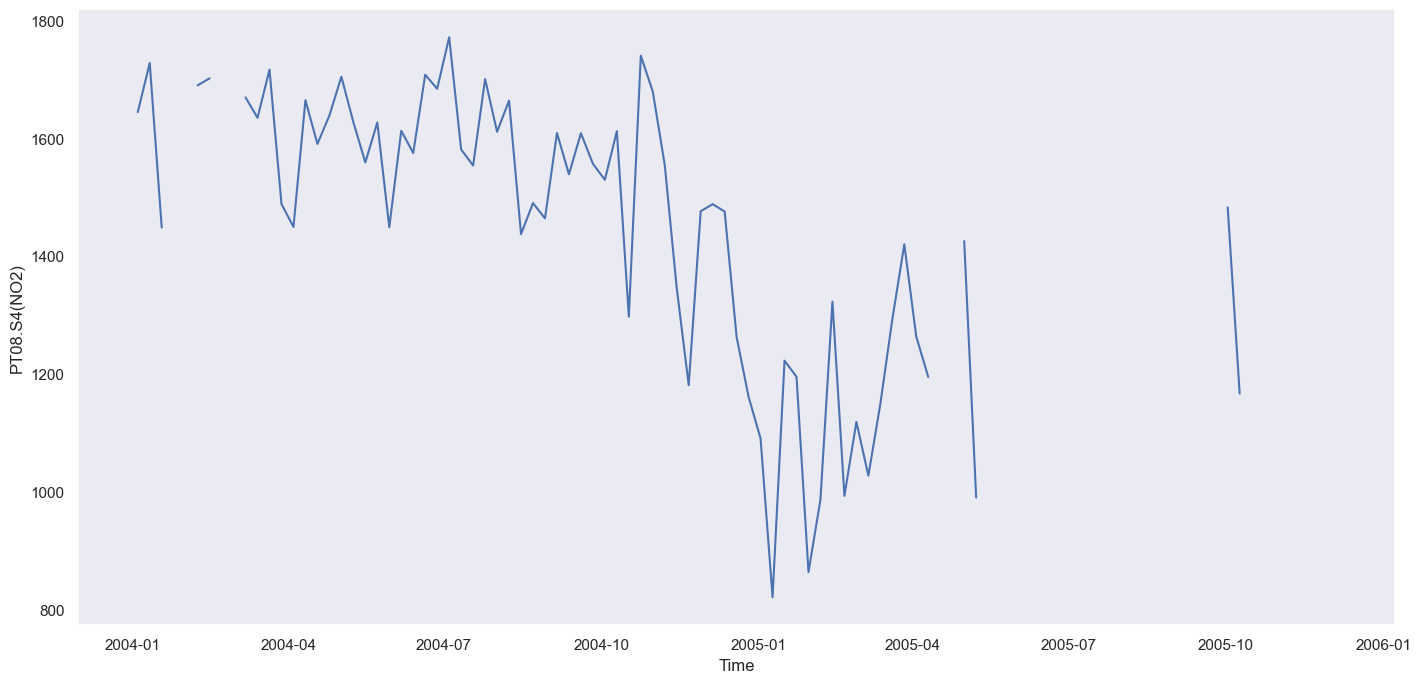

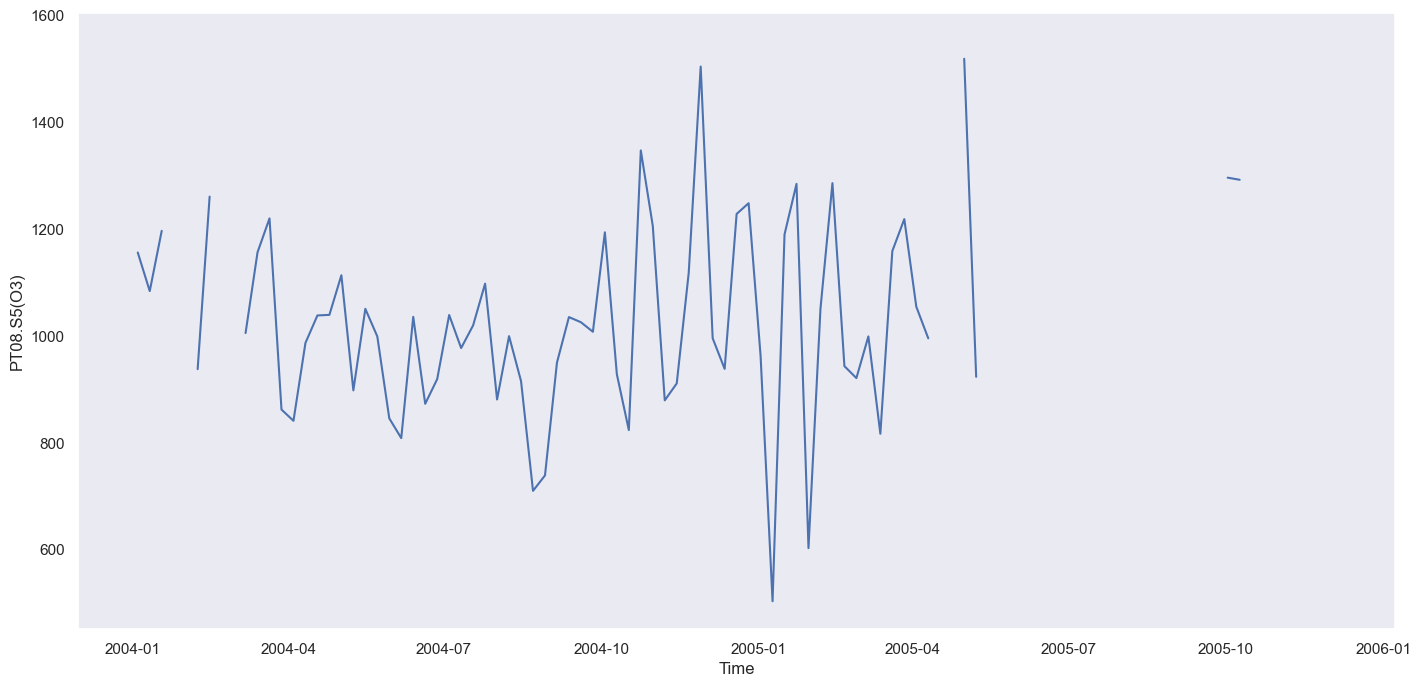

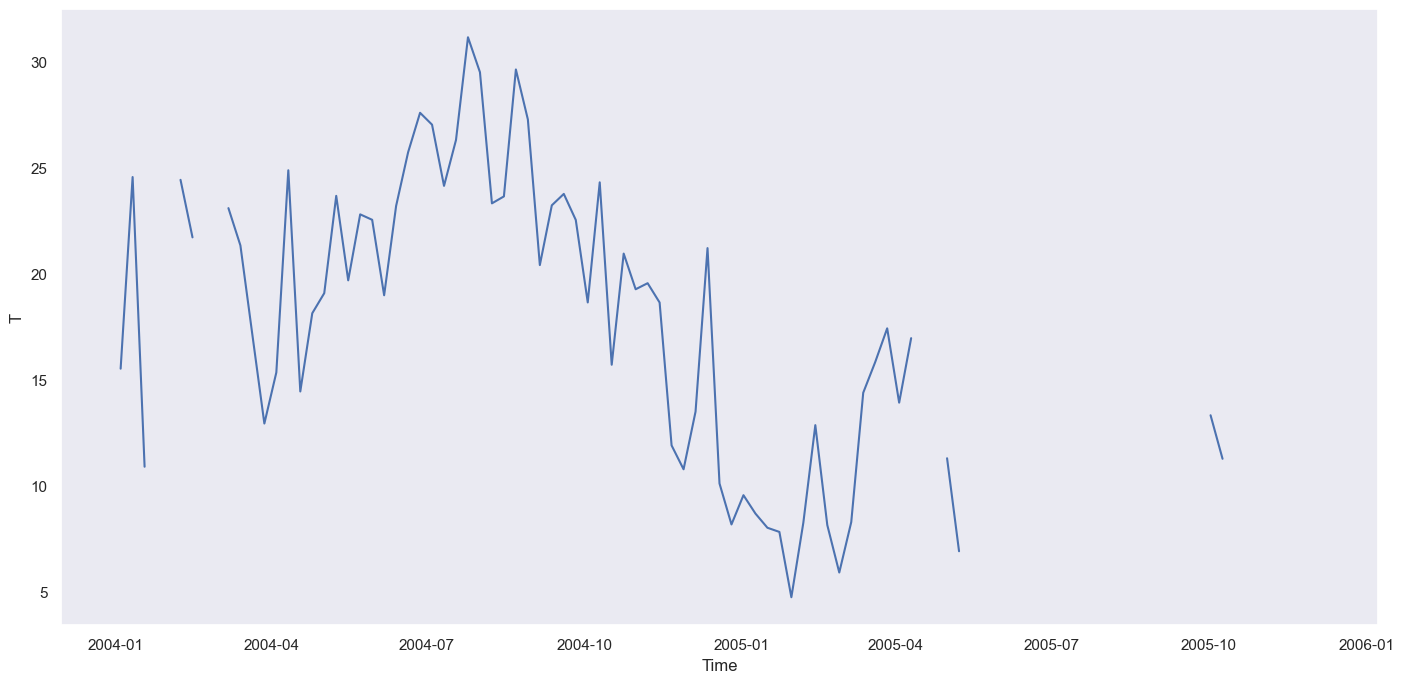

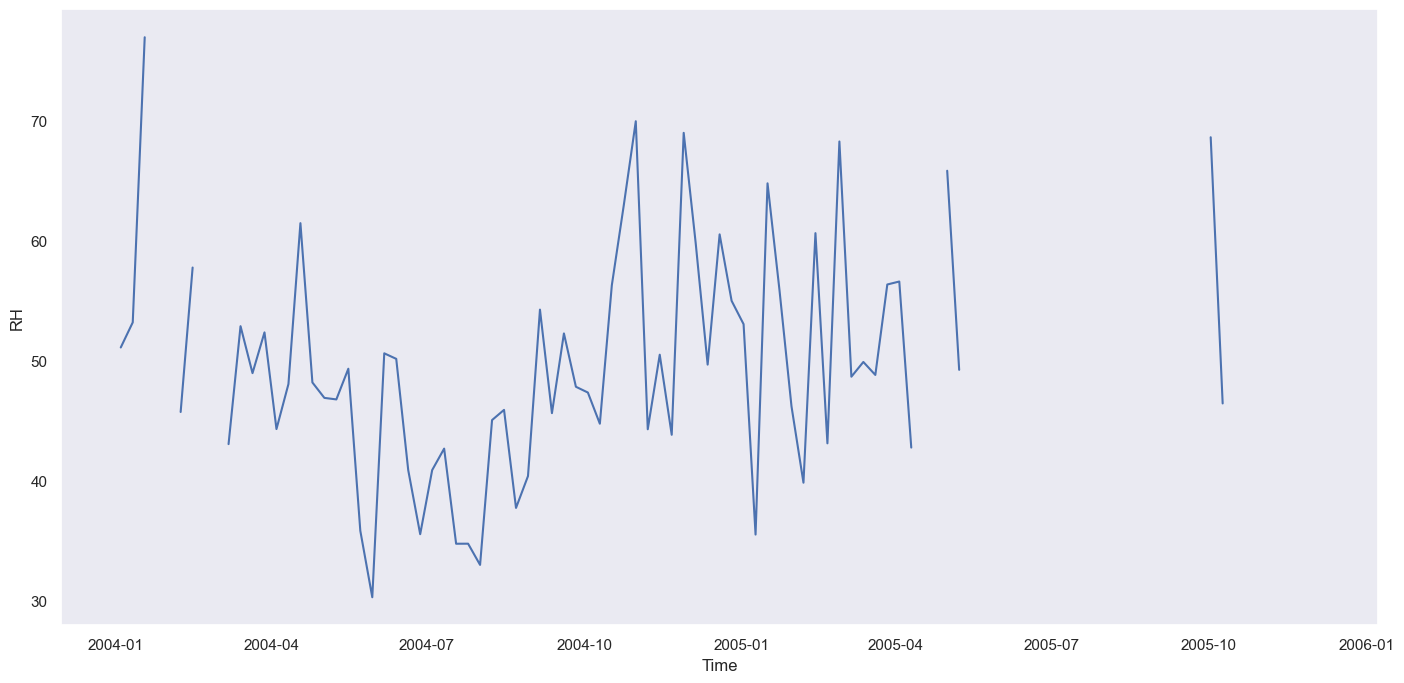

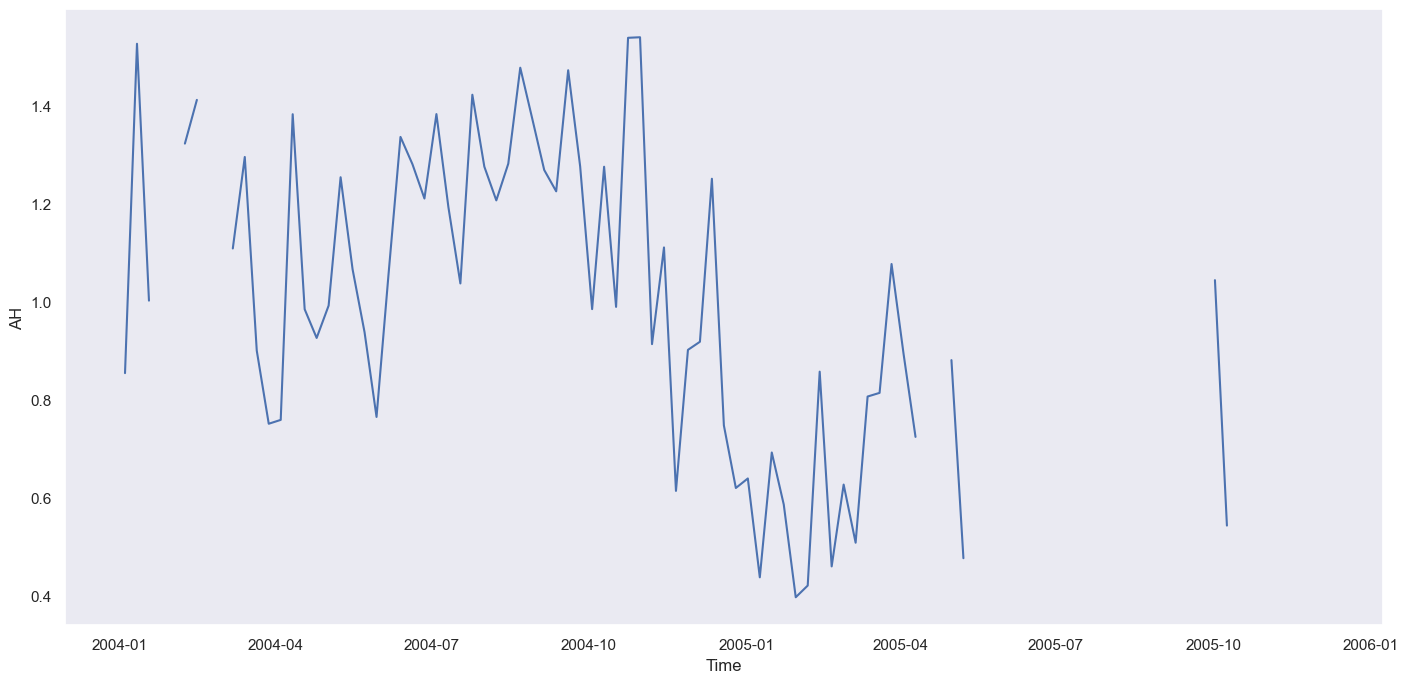

In [52]:
for col in weekly_data.columns:
    plot_data(col)

In [53]:
# Удалим ненужные столбцы
cols_to_drop = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
weekly_data = weekly_data.drop(cols_to_drop, axis=1)
weekly_data.head()

,PT08.S3(NOx)
Date,
2004-01-04,880.666667
2004-01-11,760.484990
2004-01-18,1490.333333
2004-01-25,NaN
2004-02-01,NaN


In [54]:
# Изменим имена столбцов в соответствии с гайдами Prophet
df = weekly_data.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2004-01-04,880.666667
1,2004-01-11,760.484990
2,2004-01-18,1490.333333
3,2004-01-25,NaN
4,2004-02-01,NaN


In [55]:
# Разделим данные на тренировочную и тестовую выборки
prediction_size = 30
train_df = df[:-prediction_size]

In [56]:
# Инициализируем и обучим модель
m = Prophet()
m.fit(train_df)

11:42:04 - cmdstanpy - INFO - Chain [1] start processing
11:42:04 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
# Сделаем предикт
future = m.make_future_dataframe(periods=prediction_size)
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-01-04,955.045839,795.219797,1112.400571,955.045839,955.045839,0.0,0.0,0.0,0.0,0.0,0.0,955.045839
1,2004-01-11,951.998533,778.485099,1097.737401,951.998533,951.998533,0.0,0.0,0.0,0.0,0.0,0.0,951.998533
2,2004-01-18,948.951227,779.033978,1114.059794,948.951227,948.951227,0.0,0.0,0.0,0.0,0.0,0.0,948.951227
3,2004-01-25,945.903921,778.494445,1102.373615,945.903921,945.903921,0.0,0.0,0.0,0.0,0.0,0.0,945.903921
4,2004-02-01,942.856616,778.920866,1099.292982,942.856616,942.856616,0.0,0.0,0.0,0.0,0.0,0.0,942.856616


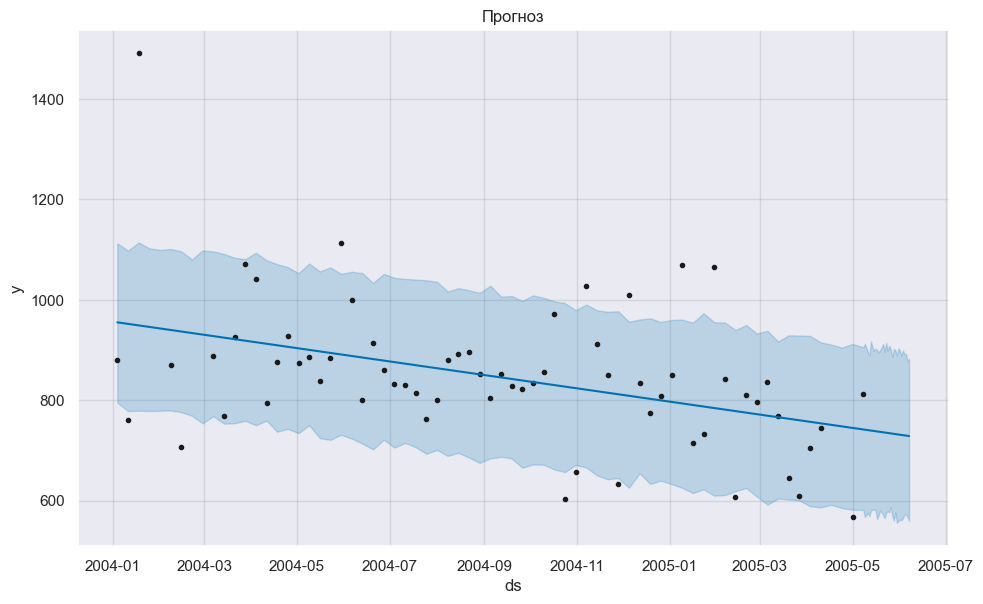

In [58]:
# Построим график прогноза
m.plot(forecast)
plt.title('Прогноз')
plt.show()

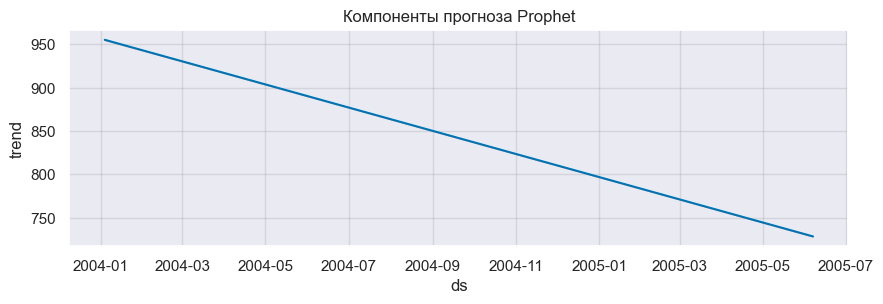

In [59]:
# Построим график с компонентами Prophet
'''
Функция позволяет посмотреть отдельно на компоненты: тренд, годовую и недельную сезонность.
Если при построении модели были заданы аномальные дни/праздники, то они также будут отображаться на этом графике.
'''
m.plot_components(forecast)
plt.title('Компоненты прогноза Prophet')
plt.show()

In [60]:
# Оценим качество модели
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [61]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2004-01-04,955.045839,795.219797,1112.400571,880.666667
2004-01-11,951.998533,778.485099,1097.737401,760.484990
2004-01-18,948.951227,779.033978,1114.059794,1490.333333
2004-01-25,945.903921,778.494445,1102.373615,NaN
2004-02-01,942.856616,778.920866,1099.292982,NaN


In [62]:
def calculate_forecast_errors(df, prediction_size):

    df = df.copy()

    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']

    predicted_part = df[-prediction_size:]

    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [63]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 20.111880905338218
MAE 183.66337241762403


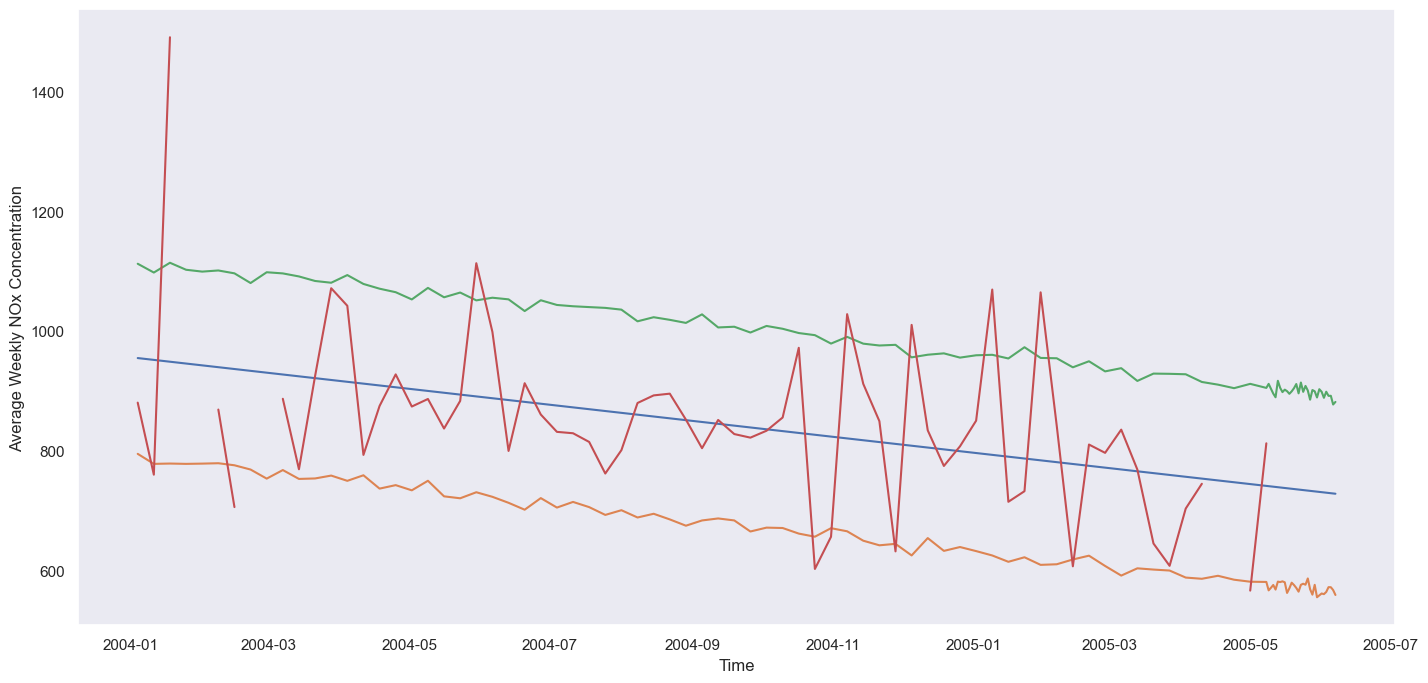

In [64]:
# Построим график прогноза с минимальными и максимальными пороговыми значениями
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly NOx Concentration')
plt.grid(False)
plt.show()

source: https://github.com/marcopeix/air-quality/